In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/26__walking_down_street_outside_angry.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/08__talking_against_wall.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/14__walking_down_indoor_hall_disgust.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/08__walking_down_street_outside_angry.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/05__outside_talking_still_laughing.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/14__exit_phone_room.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/06__walk_down_hall_angry.mp4
/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/12__outside_talking_still_laughing.mp4
/kaggle/input/deep-fake-detection-d

#  *Importing packages*

In [5]:
import numpy as np 
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os

# Check exactly where the videos are
print(os.listdir("/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"))

['13_15__walking_down_indoor_hall_disgust__X0EIIJF7.mp4', '02_25__walking_outside_cafe_disgusted__Z7FQ69VP.mp4', '02_09__kitchen_pan__9TDCEK1Q.mp4', '02_13__exit_phone_room__CP5HFV3K.mp4', '20_01__outside_talking_still_laughing__D8GWGO2A.mp4', '24_10__walking_down_street_outside_angry__356HPS7R.mp4', '09_14__talking_angry_couch__6TEK3ZX0.mp4', '11_13__podium_speech_happy__XXKQ4XM0.mp4', '20_03__hugging_happy__Z6V05FXO.mp4', '03_14__talking_against_wall__ZC2KYASW.mp4', '03_15__outside_talking_pan_laughing__Y11NT1YX.mp4', '26_12__walking_down_street_outside_angry__OVOQACG8.mp4', '21_07__hugging_happy__CRGVSDBI.mp4', '06_02__walking_and_outside_surprised__MKZTXQ2T.mp4', '15_06__exit_phone_room__E98QYYXO.mp4', '18_09__outside_talking_pan_laughing__3VP8836C.mp4', '18_09__kitchen_pan__3VP8836C.mp4', '12_06__walking_down_street_outside_angry__3K21NFNM.mp4', '20_27__walk_down_hall_angry__LM907ECA.mp4', '26_25__outside_talking_still_laughing__7ZRKCFMS.mp4', '26_18__talking_angry_couch__AI94QW74

# Dataset paths

In [7]:
REAL_PATH="/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
FAKE_PATH="/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"
OUTPUT_FRAME_SIZE=(128,128)
FRAME_COUNT=10
MAX_VIDEOS=300

In [8]:
def extract_frames(video_path,output_size=(128,128),frame_count=10):
    cap=cv2.VideoCapture(video_path)
    frames=[]
    total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [9]:
data=[]
labels=[]
print("Processing real videos...")
real_videos=os.listdir(REAL_PATH)[:MAX_VIDEOS]
for video_file in tqdm(real_videos):
    video_path=os.path.join(REAL_PATH,video_file)
    frames=extract_frames(video_path,output_size=OUTPUT_FRAME_SIZE,frame_count=FRAME_COUNT)
    if len(frames)==FRAME_COUNT:
        data.append(frames)
        labels.append(0)
print("Processing fake videos")
fake_videos=os.listdir(FAKE_PATH)[:MAX_VIDEOS]
for video_file in tqdm(fake_videos):
    video_path=os.path.join(FAKE_PATH,video_file)
    frames=extract_frames(video_path,output_size=OUTPUT_FRAME_SIZE,frame_count=FRAME_COUNT)
    if len(frames)==FRAME_COUNT:
        data.append(frames)
        labels.append(1)
    

Processing real videos...


100%|██████████| 300/300 [19:23<00:00,  3.88s/it]


Processing fake videos


100%|██████████| 300/300 [19:06<00:00,  3.82s/it]


In [10]:
X=np.array(data)
y=np.array(labels)

X_train,X_temp,y_train,y_temp=train_test_split(X,y,train_size=0.7,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,train_size=0.3,random_state=42)
#Normalize data
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255
#to categorical
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

print(f"Data shapes: Train-{X_train.shape}, Test-{X_test.shape}, Validation{X_val.shape}")

Data shapes: Train-(418, 10, 128, 128, 3), Test-(126, 10, 128, 128, 3), Validation(54, 10, 128, 128, 3)


In [11]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1
)

def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = datagen.random_transform(frame)
        augmented_frames.append(frame)
    return np.array(augmented_frames)

for _ in range(3):
    
    augmented_data = []
    augmented_labels = []
    
    print("Augmenting data...")
    for i in tqdm(range(len(X_train))):  # Ajoute tqdm pour suivre progression
        augmented_frames = augment_frames(X_train[i])
        augmented_data.append(augmented_frames)
        augmented_labels.append(y_train[i])
    
    X_train_augmented = np.concatenate((X_train, np.array(augmented_data)))
    y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)))
    
    # Correction du nom de variable ici (tu avais écrit "augmentated")
    print(f"Augmented train data: {X_train_augmented.shape}")
    print(f"Augmented train labels: {y_train_augmented.shape}")
    print(f"Original: {len(X_train)} videos, Après augmentation: {len(X_train_augmented)} videos")

Augmenting data...


100%|██████████| 418/418 [00:18<00:00, 22.17it/s]


Augmented train data: (836, 10, 128, 128, 3)
Augmented train labels: (836, 2)
Original: 418 videos, Après augmentation: 836 videos
Augmenting data...


100%|██████████| 418/418 [00:18<00:00, 22.08it/s]


Augmented train data: (836, 10, 128, 128, 3)
Augmented train labels: (836, 2)
Original: 418 videos, Après augmentation: 836 videos
Augmenting data...


100%|██████████| 418/418 [00:18<00:00, 22.09it/s]


Augmented train data: (836, 10, 128, 128, 3)
Augmented train labels: (836, 2)
Original: 418 videos, Après augmentation: 836 videos


In [25]:
# Si tes labels sont one-hot, convertir en binaire :
y_train_augmented = np.argmax(y_train_augmented, axis=1).reshape(-1, 1)
# Pareil pour y_val et y_test si nécessaire avant fit ou évaluation !
y_val_bin = np.argmax(y_val, axis=1).reshape(-1, 1)
y_test_bin = np.argmax(y_test, axis=1).reshape(-1, 1)


In [30]:
# Si tes labels sont au format one-hot (shape [N, 2]):
if y_train_augmented.shape[1] == 2:
    y_train_counts = np.argmax(y_train_augmented, axis=1)
else:
    y_train_counts = y_train_augmented.flatten()  # shape [N, 1] ou [N]

# Comptage des classes
unique, counts = np.unique(y_train_counts, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Classe {cls} : {count} samples")

print("Répartition :", dict(zip(unique, counts)))


Classe 0 : 836 samples
Répartition : {0: 836}


# Activation du gpu

In [12]:
import tensorflow as tf

# Vérifie si GPU disponible
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
print("Nombre de GPUs:", len(tf.config.list_physical_devices('GPU')))

# Si GPU trouvé
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté et activé")
    # Configure la mémoire GPU (évite les erreurs)
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Pas de GPU détecté, utilisation CPU")

TensorFlow version: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Nombre de GPUs: 2
GPU détecté et activé


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout, 
    TimeDistributed, Flatten, BatchNormalization, Activation
)
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear session pour éviter conflits
K.clear_session()

# Base ResNet
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)                    
)
base_resnet.trainable = False

# Build le modèle
input_shape = (FRAME_COUNT, 128, 128, 3)

model = Sequential([
    TimeDistributed(base_resnet, input_shape=input_shape),
    TimeDistributed(Flatten()),
    tf.keras.layers.Reshape((FRAME_COUNT, -1, 1, 1)),
    
    Conv3D(64, kernel_size=(3, 3, 1), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 1)),
    Dropout(0.3),
    
    Conv3D(128, kernel_size=(3, 3, 1), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 1)),
    Dropout(0.4),
    
    GlobalAveragePooling3D(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])



I0000 00:00:1760883972.023022      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760883972.023751      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 4, 4, 2048) │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 32768)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 32768, 1,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 10, 32768, 1,   │           640 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 32768, 1,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 16384, 1,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 16384, 1,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 16384, 1,    │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 16384, 1,    │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 8192, 1,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 8192, 1,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,729,025 (90.52 MB)

 Trainable params: 140,929 (550.50 KB)

 Non-trainable params: 23,588,096 (89.98 MB)

None


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

checkpoint=ModelCheckpoint(
    "deepfake_detection_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)


lr_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)
early_stopping=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [22]:
%%time
import warnings 
warnings.filterwarnings("ignore")
history=model.fit(X_train_augmented,y_train_augmented,validation_data=(X_val,y_val),epochs=50,batch_size=10,callbacks=[checkpoint,lr_scheduler,early_stopping])

Epoch 1/50


2025-10-19 14:50:45.106555: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[10,128,5,16384,1]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,5,16384,1]{4,3,2,1,0}, f32[128,64,3,3,1]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x1 pad=1_1x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0000 00:00:1760885448.195392    2514 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760885450.759605    2514 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigat

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.4998 - loss: 0.7291

2025-10-19 14:52:47.105356: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[6,128,5,16384,1]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,5,16384,1]{4,3,2,1,0}, f32[128,64,3,3,1]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x1 pad=1_1x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0000 00:00:1760885569.801190    2513 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760885572.134669    2513 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate 

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4998 - loss: 0.7289   

2025-10-19 14:53:44.769555: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[10,128,5,16384,1]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,5,16384,1]{4,3,2,1,0}, f32[128,64,3,3,1]{4,3,2,1,0}, f32[128]{0}), window={size=3x3x1 pad=1_1x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
E0000 00:00:1760885627.922113    2514 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760885630.520239    2514 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigat


Epoch 1: val_accuracy improved from -inf to 0.53704, saving model to deepfake_detection_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.4998 - loss: 0.7288 - val_accuracy: 0.5370 - val_loss: 0.6905 - learning_rate: 0.0100
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.4937 - loss: 0.7063
Epoch 2: val_accuracy did not improve from 0.53704
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 864ms/step - accuracy: 0.4938 - loss: 0.7063 - val_accuracy: 0.5370 - val_loss: 0.6919 - learning_rate: 0.0100
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.5094 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.53704
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 864ms/step - accuracy: 0.5092 - loss: 0.6932 - val_accuracy: 0.4630 - val_loss: 0.6952 - learning_rate: 0.0100
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.5239 - loss: 0.6940
Epoch 4: val_accuracy did not improve from 0.53704

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00499999

In [26]:
# Les prédictions du modèle
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # ou .reshape(-1, 1)

# Labels de vérité pour sklearn MUST être binaires
y_true_bin = np.argmax(y_test, axis=1)

# Métriques
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_true_bin, y_pred_classes)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_bin, y_pred_classes, target_names=['Real', 'Fake']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_bin, y_pred_classes)
print(cm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step

Test Accuracy: 0.5397

Classification Report:
              precision    recall  f1-score   support

        Real       0.54      1.00      0.70        68
        Fake       0.00      0.00      0.00        58

    accuracy                           0.54       126
   macro avg       0.27      0.50      0.35       126
weighted avg       0.29      0.54      0.38       126


Confusion Matrix:
[[68  0]
 [58  0]]


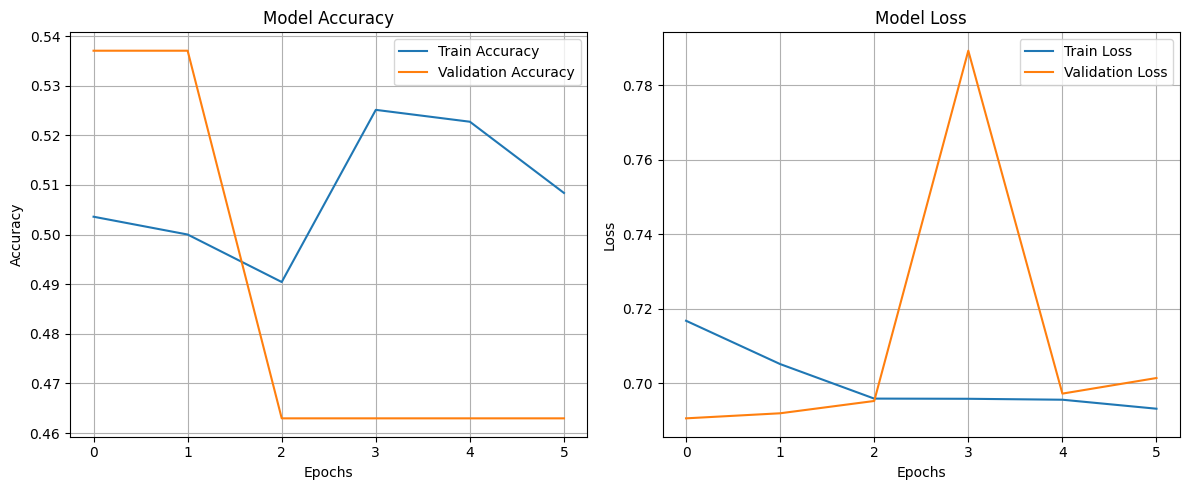

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step


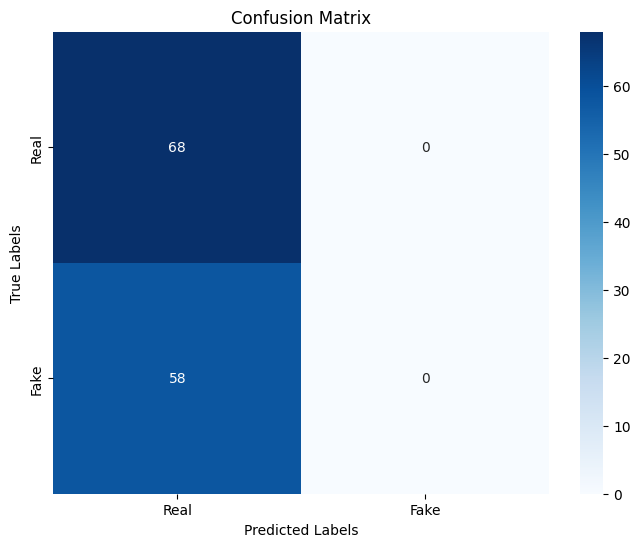


Classification Report:
              precision    recall  f1-score   support

        Real       0.54      1.00      0.70        68
        Fake       0.00      0.00      0.00        58

    accuracy                           0.54       126
   macro avg       0.27      0.50      0.35       126
weighted avg       0.29      0.54      0.38       126


Confusion Matrix Details:
True Negatives (Real as Real): 68
False Positives (Real as Fake): 0
False Negatives (Fake as Real): 58
True Positives (Fake as Fake): 0

Final Test Accuracy: 0.5397
Final Test Loss: 0.6900


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Plot accuracy and loss graphs
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
def plot_confusion_matrix(model, X_test, y_test):
    # Get predictions - CORRECTION ICI
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Pour sigmoid
    y_true = y_test  # Déjà en format binaire
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_labels = ['Real', 'Fake']
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_bin, y_pred_classes, target_names=cm_labels))
    
    # Métriques détaillées
    print(f"\nConfusion Matrix Details:")
    print(f"True Negatives (Real as Real): {cm[0,0]}")
    print(f"False Positives (Real as Fake): {cm[0,1]}")
    print(f"False Negatives (Fake as Real): {cm[1,0]}")
    print(f"True Positives (Fake as Fake): {cm[1,1]}")
    
    return cm

# Plot training history
plot_training_history(history)

# Plot confusion matrix
cm = plot_confusion_matrix(model, X_test, y_test_bin)

# Affiche les résultats finaux
test_loss, test_acc = model.evaluate(X_test, y_test_bin, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")